<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

Collection:

In [1]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
attack_type_counts = cicids2017_df['Attack Type'].value_counts()
print(attack_type_counts)

# Calculate and print total benign and malicious samples
total_benign = attack_type_counts.get('Normal Traffic', 0)
total_malicious = attack_type_counts.sum() - total_benign

print(f"\nTotal Benign Samples: {total_benign}")
print(f"Total Malicious Samples: {total_malicious}")


# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {type: i for i, type in enumerate(attack_types)}

# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Total Benign Samples: 2095057
Total Malicious Samples: 425694

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


Train/Test Split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Separate Benign and Malicious Traffic ---

# Separate benign and malicious samples
benign_df = cicids2017_df[cicids2017_df['Attack Type'] == 0]
malicious_df = cicids2017_df[cicids2017_df['Attack Type'] != 0]

# Separate features (X) and labels (y) for benign data
X_benign = benign_df.drop('Attack Type', axis=1)
y_benign = benign_df['Attack Type']

# Separate features (X) and labels (y) for malicious data
X_malicious = malicious_df.drop('Attack Type', axis=1)
y_malicious = malicious_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X_benign, y_benign, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Create test set
X_test = pd.concat([X_test, X_malicious], ignore_index=True)
y_test = pd.concat([y_test, y_malicious], ignore_index=True)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Visualise Training set ???

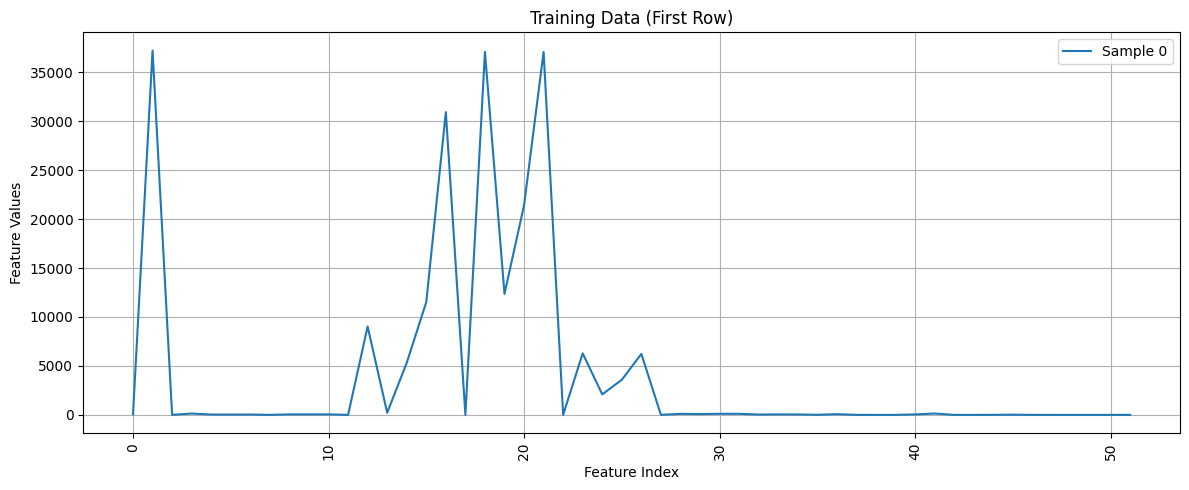

In [3]:
import matplotlib.pyplot as plt

# Use range for x-axis labels as X_train is a NumPy array
x_labels = range(X_train.shape[1])

plt.figure(figsize=(12, 5))  # Wider figure
plt.plot(x_labels, X_train.iloc[0], label='Sample 0') # Access the first row using array indexing
plt.title("Training Data (First Row)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Values")
plt.grid(True)
plt.legend()

# Fix x-axis ticks
plt.xticks(rotation=90)  # Rotate if labels are long
plt.tight_layout()
plt.show()

Visualise Split

Input Shapes -> Train: (1340836, 52), Val: (335209, 52), Test: (844706, 52)
Labels distribution -> Train: [1340836       0       0       0       0       0       0], Val: [335209      0      0      0      0      0      0], Test: [419012  90694   2143   9150 128014   1948 193745]


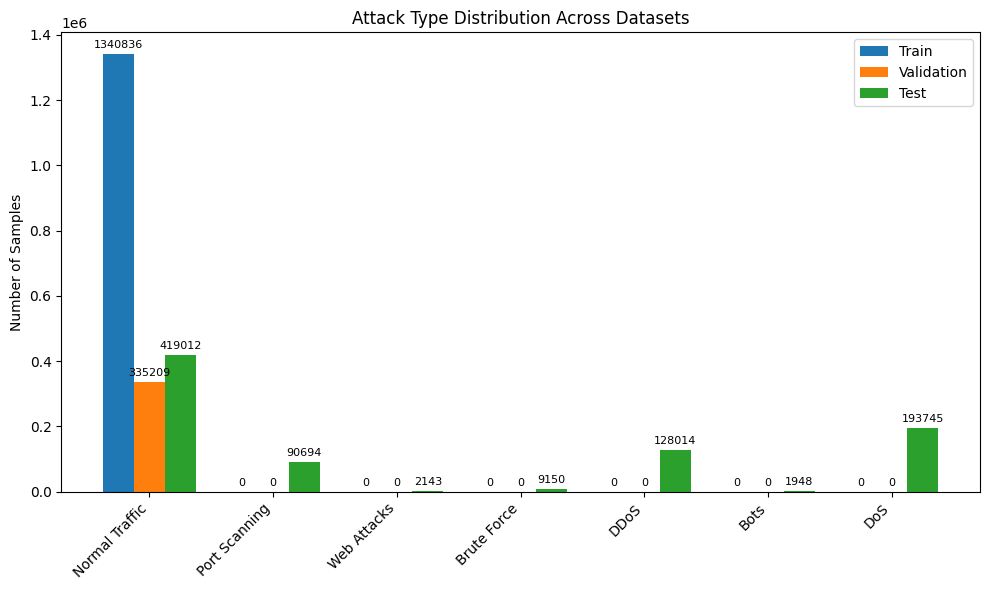

In [4]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

Normalise the data:

In [5]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
# Initialize the scaler
#scaler = RobustScaler()
#scaler = StandardScaler()
scaler = MinMaxScaler()

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")



Shape of X_train after scaling: (1340836, 52)
Shape of X_val after scaling: (335209, 52)
Shape of X_test after scaling: (844706, 52)


Visualise normalised benign data

/tmp/ipython-input-2641110746.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


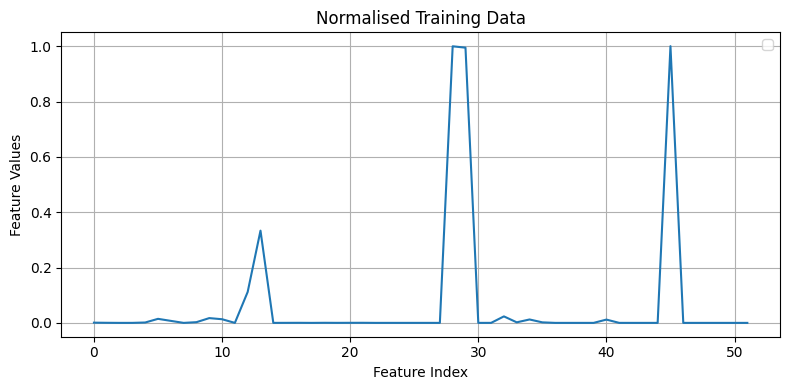

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(X_train[0])
# plt.plot(X_train[2])
# plt.plot(X_train[3])
# plt.plot(X_train[4])
# plt.plot(X_train[5])
# plt.plot(X_train[6])
plt.title("Normalised Training Data")
plt.xlabel('Feature Index')
plt.ylabel('Feature Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8, 4))
# plt.plot(X_train)
# plt.title("Normalised Training Data")
# plt.xlabel('Feature Index')
# plt.ylabel('Feature Values')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

#Autoencoder model
An autoencoder model consists of two parts:
- **Encoder**: Responsible for compressing the input data into a lower-dimensional representation of the input data that captures the most important information.
- **Decoder**: Responsible for reconstructing the input data from the latent space representation. The decoder takes the latent space representation as input and produces a reconstructed version of the input data as output. The reconstructed data should be as similar as possible to the original input data.

- Advantages of autoencoders: Can be used to detect anomalies, unsupervised learning models (they do not require labeled data in training), easy to train and implement.
- Disadvantages of autoencoders: computationally expensive to train (especially for large datasets.), they are sensitive to the choice of hyperparameters, difficult to interpret.

Below is a simple autoencoder model with three layers in the encoder and three layers in the decoder. https://levelup.gitconnected.com/build-deep-autoencoders-model-for-anomaly-detection-in-python-a-complete-guide-a7d0ec0e688
https://medium.com/@ndhilani.simbine/how-i-built-a-real-time-anomaly-detection-system-for-enterprise-networks-using-python-and-machine-0078d8a26e84
https://medium.com/@walid.daboubi/malware-detection-using-deep-autoencoder-neural-network-wannacry-as-a-test-9d0125c925b2

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU, Dropout
import numpy as np # Import numpy

# Determine the input dimension from the scaled training data
autoencoder_input_dim = X_train.shape[1]
print(f"Autoencoder input dimension: {autoencoder_input_dim}")

autoencoder = Sequential([
    Input(shape=(autoencoder_input_dim,)),
    Dense(64, activation='relu'),                             # Encoder layer
    Dense(32, activation='relu'),                             # Encoder layer
    Dense(16, activation='relu'),                             # Encoder bottleneck
    Dense(32, activation='relu'),                             # Decoder layer
    Dense(64, activation='relu'),                             # Decoder layer
    Dense(autoencoder_input_dim, activation='sigmoid')         # Output layer (same size as input)
])

autoencoder.compile(optimizer='adam', loss='mse')


Autoencoder input dimension: 52


# Train and test the model

Epoch 1/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 0.0037 - val_loss: 7.3655e-05
Epoch 2/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 6.1369e-05 - val_loss: 4.5874e-05
Epoch 3/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 4.1054e-05 - val_loss: 3.2478e-05
Epoch 4/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 3.1939e-05 - val_loss: 3.0406e-05
Epoch 5/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 2.5995e-05 - val_loss: 2.1305e-05
Epoch 6/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 2.3283e-05 - val_loss: 2.1359e-05
Epoch 7/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 2.1319e-05 - val_loss: 2.7274e-05
Epoch 8/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 2.1398e-05 - val_loss: 1.9654e-05
Epoch 9/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 2.0319e-05 - val_loss: 1.7440e-05
Epoch 10/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 1.7509e-05 - val_loss: 2.0298e-05
Training time

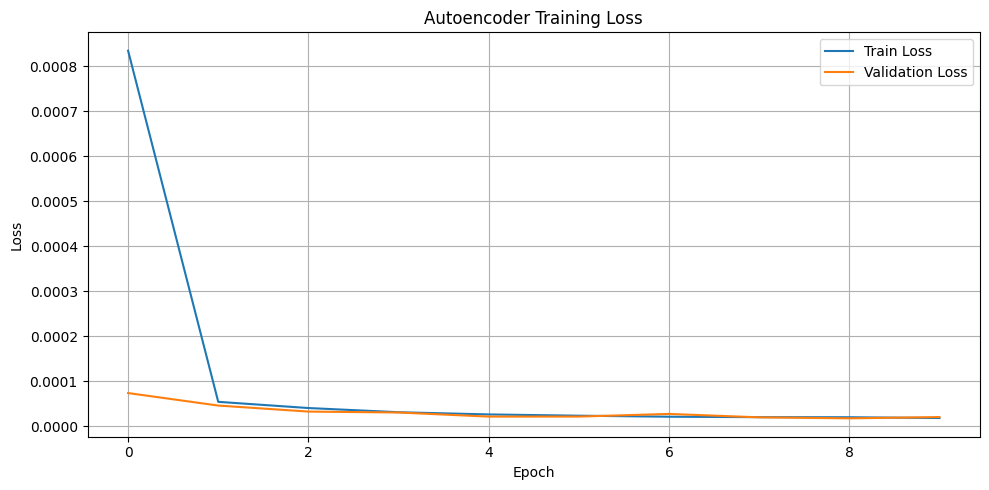

In [8]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
    verbose=1
)


# End timing
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot training and validation loss graph
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#Test the model

Establish the threshold

In [9]:
import tensorflow as tf
import numpy as np

# --- Getting Threshold ----
# Get reconstructions and reconstruction errors of the training data
print("Getting average reconstruction error from the training data to determine a threshold...")
training_reconstructions = autoencoder.predict(X_train, verbose=0) # Added verbose=0 to reduce output during prediction

#TESTING:
#training_reconstruction_errors = np.sum(np.square(reconstructions - X_test), axis=1)# Calculate the sum of reconstruction error for each feature for each sample in the training dataset.
training_reconstruction_errors = np.mean(np.square(training_reconstructions - X_train), axis=1)

# Inspect first row
np.set_printoptions(precision=4, suppress=True)
print("original training data (first row):\n", X_train[0])
print("training_reconstructions (first row):\n", training_reconstructions[0])
print("training_reconstruction_errors (first row):\n", training_reconstruction_errors[0])

# Set the threshold -> Taking the average sum of reconstruction errors
threshold = np.mean(training_reconstruction_errors) #+ np.std(train_loss) # Choosing a threshold value that is one standard deviations above the mean.
# threshold = np.percentile(training_reconstruction_errors, 95)

print(f"Threshold value: {threshold}")


Getting average reconstruction error from the training data to determine a threshold...
original training data (first row):
 [0.0008 0.0003 0.     0.0001 0.0014 0.0146 0.0073 0.     0.0026 0.0173
 0.0132 0.     0.1119 0.3334 0.     0.0001 0.0003 0.     0.0003 0.0001
 0.0003 0.0003 0.     0.0001 0.     0.     0.0001 0.     0.9995 0.9946
 0.     0.0001 0.0235 0.002  0.0123 0.0019 0.     0.     0.     0.
 0.0119 0.0001 0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.    ]
training_reconstructions (first row):
 [0.0008 0.0003 0.     0.     0.0007 0.0141 0.0055 0.     0.0021 0.0154
 0.0126 0.0002 0.1119 0.3345 0.0001 0.0003 0.0003 0.     0.0003 0.0002
 0.0002 0.0003 0.0001 0.0001 0.0003 0.0001 0.0003 0.     0.9995 0.9946
 0.0012 0.0015 0.0227 0.0016 0.0104 0.0031 0.0001 0.     0.     0.
 0.0113 0.     0.0003 0.     0.     1.     0.     0.     0.     0.0001
 0.0001 0.0001]
training_reconstruction_errors (first row):
 3.7310017069375805e-07
Threshold value: 1.3961160334201408e-0

Test the model on the test dataset

In [10]:
import tensorflow as tf
import numpy as np

# Get reconstructions and errors for test data
test_reconstructions = autoencoder.predict(X_test)

#TESTING
#test_reconstruction_errors = np.sum(np.square(test_reconstructions - X_test), axis=1)
test_reconstruction_errors = np.mean(np.square(test_reconstructions - X_test), axis=1) # Reconstruction error: Mean Squared Error per sample

# Display first row of data
np.set_printoptions(precision=4, suppress=True)
print("Original test data (first row):\n", X_test[0])
print("\nReconstructed test data (first row):\n", test_reconstructions[0])
print("\n Reconstruction error (first row):\n", test_reconstruction_errors[0])

# Identify anomalies (1 or 0)
y_pred = (test_reconstruction_errors > threshold).astype(int)
traffic_anomalies = np.where(y_pred == 1)[0]


26398/26398 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
Original test data (first row):
 [0.0012 0.0013 0.     0.     0.0008 0.     0.0019 0.0015 0.2243 0.
 0.5105 0.4858 0.112  0.3333 0.0002 0.0006 0.0013 0.     0.     0.
 0.     0.     0.     0.0013 0.0003 0.0008 0.0013 0.     0.9995 0.9946
 0.     0.     0.     0.1765 0.3484 0.4089 0.1671 0.     1.     0.
 0.3318 0.     0.125  0.0035 0.     1.     0.     0.     0.     0.
 0.     0.    ]

Reconstructed test data (first row):
 [0.0005 0.0059 0.     0.001  0.0168 0.     0.0121 0.0255 0.2277 0.0003
 0.5283 0.4646 0.1107 0.3243 0.0006 0.0038 0.0066 0.     0.0005 0.
 0.0003 0.0003 0.     0.0016 0.0001 0.0019 0.0015 0.     0.9996 0.9949
 0.     0.     0.     0.1756 0.3151 0.3785 0.1499 0.     1.     0.
 0.288  0.0011 0.1341 0.003  0.     0.9999 0.     0.     0.     0.0028
 0.0018 0.0032]

 Reconstruction error (first row):
 0.000119355702271145


# Evaluate model predictions against ground truth

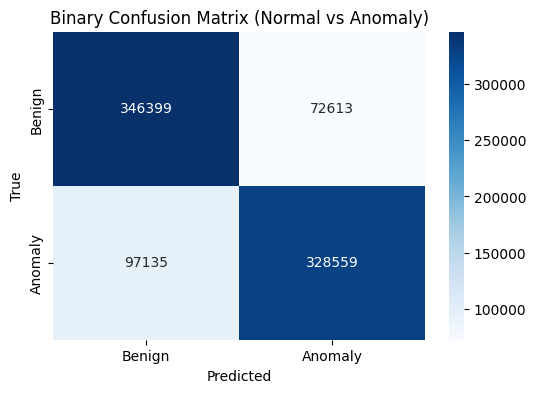


Accuracy:
sklearn Accuracy: 0.7990448747848364

Classification Report:
              precision    recall  f1-score   support

      Benign       0.78      0.83      0.80    419012
     Anomaly       0.82      0.77      0.79    425694

    accuracy                           0.80    844706
   macro avg       0.80      0.80      0.80    844706
weighted avg       0.80      0.80      0.80    844706


Anomaly Detection Metrics:
True Positives (Anomalies correctly detected): 328559
True Negatives (Normal Traffic correctly identified): 346399
False Positives (Normal Traffic misclassified as Anomaly): 72613
False Negatives (Anomalies missed): 97135

Percentage of Anomalies Detected: 77.18%
Percentage of Normal Traffic Misclassified (False Positive Rate): 17.33%


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test to binary: 0 = Normal, 1 = Anomaly
y_test_binary = (y_test != 0).astype(int)

# --- Confusion matrix ---
cm = confusion_matrix(y_test_binary, y_pred)

# --- Heatmap ---
# Labels for the binary confusion matrix
binary_labels = ['Benign', 'Anomaly']

# Plot heatmap
plt.figure(figsize=(6, 4)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=binary_labels, yticklabels=binary_labels)
plt.title("Binary Confusion Matrix (Normal vs Anomaly)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test_binary, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names for binary classification
report = classification_report(y_test_binary, y_pred, target_names=binary_labels, output_dict=True)
print(classification_report(y_test_binary, y_pred, target_names=binary_labels))

# --- Custom Metrics for Anomaly Detection ---
# From the confusion matrix:
tn, fp, fn, tp = cm.ravel() # Unpack confusion matrix values

print("\nAnomaly Detection Metrics:")
print(f"True Positives (Anomalies correctly detected): {tp}")
print(f"True Negatives (Normal Traffic correctly identified): {tn}")
print(f"False Positives (Normal Traffic misclassified as Anomaly): {fp}")
print(f"False Negatives (Anomalies missed): {fn}")

# Calculate percentages
total_anomalies = tp + fn
total_normal = tn + fp

percentage_anomalies_detected = (tp / total_anomalies) * 100 if total_anomalies > 0 else 0
percentage_normal_misclassified = (fp / total_normal) * 100 if total_normal > 0 else 0

print(f"\nPercentage of Anomalies Detected: {percentage_anomalies_detected:.2f}%")
print(f"Percentage of Normal Traffic Misclassified (False Positive Rate): {percentage_normal_misclassified:.2f}%")

# Input Vs Reconstructed Output

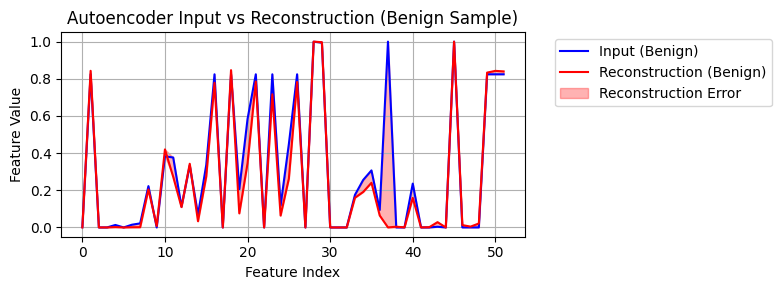

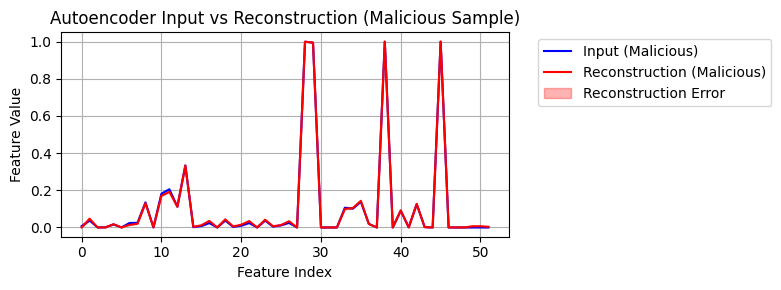

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Find the index of a benign and a malicious sample in the test set
benign_sample_indices = y_test[y_test == 0].index
malicious_sample_indices = y_test[y_test != 0].index


# Ensure there are benign and malicious samples in the test set before proceeding
if len(benign_sample_indices) > 0:
    benign_sample_idx_in_test_set = benign_sample_indices[0] # Get the first benign sample indice from the test set
else:
    benign_sample_idx_in_test_set = None
    print("No benign samples found in the test set.")

if len(malicious_sample_indices) > 0:
    malicious_sample_idx_in_test_set = malicious_sample_indices[0] # Get the first malicious sample indice from the test set
else:
    malicious_sample_idx_in_test_set = None
    print("No malicious samples found in the test set.")


# --- Plot Benign Sample ---
if benign_sample_idx_in_test_set is not None:
    input_sample_benign = X_test[benign_sample_idx_in_test_set]
    reconstructed_sample_benign = test_reconstructions[benign_sample_idx_in_test_set]

    plt.figure(figsize=(8, 3))
    plt.plot(input_sample_benign, label='Input (Benign)', color='blue')
    plt.plot(reconstructed_sample_benign, label='Reconstruction (Benign)', color='red')

    # Fill in error gap
    plt.fill_between(np.arange(len(input_sample_benign)),
                     np.minimum(input_sample_benign, reconstructed_sample_benign),
                     np.maximum(input_sample_benign, reconstructed_sample_benign),
                     color='red', alpha=0.3, label='Reconstruction Error')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.title("Autoencoder Input vs Reconstruction (Benign Sample)")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot Malicious Sample ---
if malicious_sample_idx_in_test_set is not None:
    input_sample_malicious = X_test[malicious_sample_idx_in_test_set]
    reconstructed_sample_malicious = test_reconstructions[malicious_sample_idx_in_test_set]

    plt.figure(figsize=(8, 3))
    plt.plot(input_sample_malicious, label='Input (Malicious)', color='blue')
    plt.plot(reconstructed_sample_malicious, label='Reconstruction (Malicious)', color='red')

    # Error band
    plt.fill_between(np.arange(len(input_sample_malicious)),
                     np.minimum(input_sample_malicious, reconstructed_sample_malicious),
                     np.maximum(input_sample_malicious, reconstructed_sample_malicious),
                     color='red', alpha=0.3, label='Reconstruction Error')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.title("Autoencoder Input vs Reconstruction (Malicious Sample)")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Malware Classifier


*   Softmax classifier
*   XGBoost
*   CNN?


In [13]:
# import numpy as np

# class SoftmaxClassifier:
#     def __init__(self, input_dim, num_classes, learning_rate=0.01):
#         self.input_dim = input_dim
#         self.num_classes = num_classes
#         self.learning_rate = learning_rate
#         self.weights = np.random.randn(input_dim, num_classes) * 0.01
#         self.bias = np.zeros((1, num_classes))

#     def softmax(self, z):
#         exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
#         return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

#     def cross_entropy_loss(self, y_true, y_pred):
#         m = y_true.shape[0]
#         log_likelihood = -np.log(y_pred[range(m), y_true])
#         loss = np.sum(log_likelihood) / m
#         return loss

#     def one_hot(self, y):
#         one_hot_labels = np.zeros((y.size, self.num_classes))
#         one_hot_labels[np.arange(y.size), y] = 1
#         return one_hot_labels

#     def train(self, X, y, epochs=100):
#         m = X.shape[0]
#         for epoch in range(epochs):
#             # Forward pass
#             logits = np.dot(X, self.weights) + self.bias
#             probs = self.softmax(logits)

#             # Loss (optional print)
#             loss = self.cross_entropy_loss(y, probs)
#             if epoch % 10 == 0:
#                 print(f"Epoch {epoch}: Loss = {loss:.4f}")

#             # Backpropagation
#             y_one_hot = self.one_hot(y)
#             gradient_logits = (probs - y_one_hot) / m

#             grad_weights = np.dot(X.T, gradient_logits)
#             grad_bias = np.sum(gradient_logits, axis=0, keepdims=True)

#             # Gradient descent update
#             self.weights -= self.learning_rate * grad_weights
#             self.bias -= self.learning_rate * grad_bias

#     def predict(self, X):
#         logits = np.dot(X, self.weights) + self.bias
#         probs = self.softmax(logits)
#         return np.argmax(probs, axis=1)


Get data for classiifer training

Training the Classifier

In [14]:
# input_dim = X_train_malware.shape[1]
# num_classes = len(np.unique(y_train_malware))

# classifier = SoftmaxClassifier(input_dim=input_dim, num_classes=num_classes)
# classifier.train(X_train_malware, y_train_malware, epochs=10)


Predicting Malware Class for Anomalies

In [15]:
# y_pred_classes = classifier.predict(X_anomalies)

# # Optionally evaluate
# from sklearn.metrics import classification_report
# print(classification_report(y_anomalies, y_pred_classes))
